# H2O AutoML example with multivariate time series
- this notebook was designed to run on Google's Colaboratory platform (https://colab.research.google.com)
- the feature matrix consists of lags of the target signal and lags of other features
- H2O's AutoML is used to forecast the target signal 
- unlike an LSTM model, this type of model has no memory and is unaware of any temporal structure
- for info on the dataset used and the methodology see: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 

## Install Java

- necessary for H2O
- version 8
- note the exclamation '!' is a cell magic that allows us to execute commands (in this case Ubuntu linux)


-note: Colab won't persist installations or your working directory

In [0]:
!apt-get install openjdk-8-jdk -qq > /dev/null

## install h2o library

In [2]:
!pip install h2o -qq

    100% |████████████████████████████████| 120.9MB 176kB/s 


## Import Dependencies

In [0]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
from scipy import stats


%matplotlib inline

## Read pollution.csv into pandas df
- set date as index
- display first 5 rows
- the Air Pollution data is discussed here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- this is a dataset that reports on the weather and the level of pollution each hour for five years at the US embassy in Beijing, China.
- we can use this data and frame a forecasting problem where, given the weather conditions and pollution for prior hours, we forecast the pollution at the next hour.

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/sagarmk/Forecasting-on-Air-pollution-with-RNN-LSTM/master/pollution.csv',index_col=0)

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [8]:
print('number of rows = ', df.shape[0])

number of rows =  43800


## Plot the data
- for this step, we'll use the same code used here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

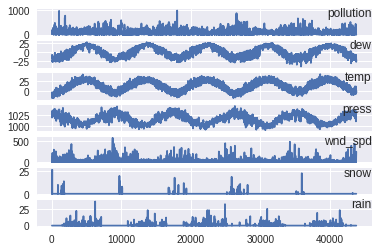

In [9]:
# specify columns to plot
values = df.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

## Inorder to model the time-series with conventional supervised machine learning, the data must be preprocessed 
- in this case, we will just predict the target signal ('pollution') one step ahead
- the features and the target will be lagged by num_lags and aggregated by mean with windows of num_lags

In [10]:
df2 = df.copy()
num_lags = 3 # number of lags and window lenghts for mean aggregation
delay = 1 # predict target one step ahead
for column in df2:
    for lag in range(1,num_lags+1):
        df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
        if column != 'wnd_dir':
            df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))

df2.dropna(inplace=True) 

mask = (df2.columns.str.contains('pollution') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
df_processed = df2[df2.columns[mask]]

# the columns in the processed dataframe
df_processed.columns

Index(['pollution', 'pollution_lag1', 'pollution_avg_window_length2',
       'pollution_lag2', 'pollution_avg_window_length3', 'pollution_lag3',
       'pollution_avg_window_length4', 'dew_lag1', 'dew_avg_window_length2',
       'dew_lag2', 'dew_avg_window_length3', 'dew_lag3',
       'dew_avg_window_length4', 'temp_lag1', 'temp_avg_window_length2',
       'temp_lag2', 'temp_avg_window_length3', 'temp_lag3',
       'temp_avg_window_length4', 'press_lag1', 'press_avg_window_length2',
       'press_lag2', 'press_avg_window_length3', 'press_lag3',
       'press_avg_window_length4', 'wnd_dir_lag1', 'wnd_dir_lag2',
       'wnd_dir_lag3', 'wnd_spd_lag1', 'wnd_spd_avg_window_length2',
       'wnd_spd_lag2', 'wnd_spd_avg_window_length3', 'wnd_spd_lag3',
       'wnd_spd_avg_window_length4', 'snow_lag1', 'snow_avg_window_length2',
       'snow_lag2', 'snow_avg_window_length3', 'snow_lag3',
       'snow_avg_window_length4', 'rain_lag1', 'rain_avg_window_length2',
       'rain_lag2', 'rain_avg_win

## Take a look at the pollution lags and windows

In [11]:
mask = df_processed.columns.str.contains('pollution')
df_processed[df_processed.columns[mask]].head(10)

,pollution,pollution_lag1,pollution_avg_window_length2,pollution_lag2,pollution_avg_window_length3,pollution_lag3,pollution_avg_window_length4
date,,,,,,,
2010-01-02 00:00:00,129.0,148.0,153.5,159.0,162.666667,181.0,156.50
2010-01-02 01:00:00,148.0,159.0,170.0,181.0,159.333333,138.0,146.75
2010-01-02 02:00:00,159.0,181.0,159.5,138.0,142.666667,109.0,133.25
2010-01-02 03:00:00,181.0,138.0,123.5,109.0,117.333333,105.0,119.00
2010-01-02 04:00:00,138.0,109.0,107.0,105.0,112.666667,124.0,114.50
2010-01-02 05:00:00,109.0,105.0,114.5,124.0,116.333333,120.0,120.25
2010-01-02 06:00:00,105.0,124.0,122.0,120.0,125.333333,132.0,129.00
2010-01-02 07:00:00,124.0,120.0,126.0,132.0,130.666667,140.0,136.00
2010-01-02 08:00:00,120.0,132.0,136.0,140.0,141.333333,152.0,143.00


## perform train/test split
- split the data sequentially mainting chronological order
- 80% train/ 20% test

In [0]:
df_processed.reset_index(drop=True,inplace=True)
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

## plot the train/test split

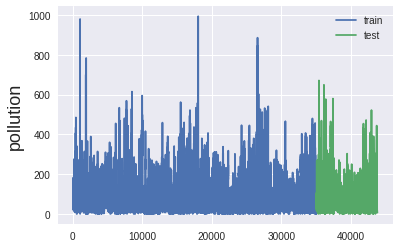

In [13]:
plt.plot(df_train.index,df_train['pollution'])
plt.plot(df_test.index,df_test['pollution'])
plt.ylabel('pollution',fontsize=18)
plt.legend(['train','test'])
plt.show()

## Initialize h2o session

In [14]:
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpun2oxa6l
  JVM stdout: /tmp/tmpun2oxa6l/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpun2oxa6l/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_unknownUser_o5ce22
H2O cluster total nodes:,1
H2O cluster free memory:,3 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


## accessing H2OFlow UI
- by default H2OFlow UI will open on localhost port 54321
- accessing this UI is optional
- on google colab, if you want to access H2OFlow, you will need to tunnel in to the localhost
   - we'll use a Nodejs package to accomplish this
- for more information on H2OFlow: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/flow.html

In [15]:
!npm install -g localtunnel -qq > /dev/null

In [0]:
get_ipython().system_raw('lt --port 54321 >> url.txt 2>&1 &')

### open the follwoing link to H2OFlow if desired 

In [17]:
!cat url.txt

your url is: https://purple-otter-30.localtunnel.me


## Convert pandas dataframes to h2o frames

In [18]:
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
hf_train.describe()

Rows:35037
Cols:46




,pollution,pollution_lag1,pollution_avg_window_length2,pollution_lag2,pollution_avg_window_length3,pollution_lag3,pollution_avg_window_length4,dew_lag1,dew_avg_window_length2,dew_lag2,dew_avg_window_length3,dew_lag3,dew_avg_window_length4,temp_lag1,temp_avg_window_length2,temp_lag2,temp_avg_window_length3,temp_lag3,temp_avg_window_length4,press_lag1,press_avg_window_length2,press_lag2,press_avg_window_length3,press_lag3,press_avg_window_length4,wnd_dir_lag1,wnd_dir_lag2,wnd_dir_lag3,wnd_spd_lag1,wnd_spd_avg_window_length2,wnd_spd_lag2,wnd_spd_avg_window_length3,wnd_spd_lag3,wnd_spd_avg_window_length4,snow_lag1,snow_avg_window_length2,snow_lag2,snow_avg_window_length3,snow_lag3,snow_avg_window_length4,rain_lag1,rain_avg_window_length2,rain_lag2,rain_avg_window_length3,rain_lag3,rain_avg_window_length4
type,int,int,real,int,real,int,real,int,real,int,real,int,real,int,real,int,real,int,real,real,real,real,real,real,real,enum,enum,enum,real,real,real,real,real,real,int,real,int,real,int,real,int,real,int,real,int,real
mins,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-33.0,-32.5,-33.0,-32.333333333333336,-33.0,-31.5,-19.0,-18.5,-19.0,-18.666666666666668,-19.0,-18.5,991.0,991.0,991.0,991.3333333333334,991.0,991.75,,,,0.45,0.6699999999998757,0.45,0.5966666666663781,0.45,0.6699999999987535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,93.36549932928058,93.36247395610361,93.36064731569459,93.35882067528613,93.35874456526892,93.35493906441785,93.35667294574304,1.7743813682678187,1.774295744498676,1.7742101207295118,1.774181579473128,1.773953249422043,1.7740317378771024,12.154693609612686,12.154836315894626,12.154979022176542,12.154998049680815,12.15532151725317,12.15516454034306,1016.3997773781998,1016.3996917544328,1016.3996061306625,1016.3995966169106,1016.3994063418685,1016.3994919656368,,,,24.957655050375337,24.959479407483837,24.96130376459178,24.961363320680015,24.965131147073134,24.96329080686061,0.05748209036161772,0.05748209036161772,0.05748209036161772,0.057482090361617694,0.05748209036161772,0.0574749550475212,0.20989239946342433,0.2098923994634244,0.20989239946342433,0.20989239946342442,0.20989239946342433,0.20989239946342433
maxs,994.0,994.0,983.0,994.0,865.3333333333334,994.0,855.0,28.0,28.0,28.0,28.0,28.0,28.0,41.0,41.0,41.0,41.0,41.0,40.75,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,,,,585.6,583.5899999999997,585.6,581.58,585.6,579.5699999999994,27.0,26.5,27.0,26.0,27.0,25.5,36.0,35.5,36.0,35.0,36.0,34.5
sigma,91.91025864899358,91.91083022692456,90.816767204728,91.91120230473103,89.97156220224014,91.91130184370424,89.18544765954863,14.494245647416877,14.478716729023043,14.494479282813261,14.465956798069655,14.494785419767135,14.453505854826703,12.30718345069174,12.284682250601287,12.306924751796219,12.260385243735554,12.306614297205664,12.23209869901723,10.386615878686598,10.380773178783398,10.386605980920418,10.374856748136967,10.386584812040583,10.368012708638854,,,,51.31115782014467,50.661545347005465,51.314118858612034,50.15115419961667,51.3175242597527,49.67473886864784,0.7738710029485413,0.7544674396038666,0.7738710029485413,0.739272499343031,0.7738710029485413,0.7251850039981366,1.4899906873477353,1.4530405905633517,1.4899906873477353,1.4253262927082684,1.4899906873477353,1.4005950908345153
zeros,1946,1946,1766,1946,1680,1946,1616,636,344,636,240,636,178,882,518,882,376,882,285,0,0,0,0,0,0,,,,0,0,0,0,0,0,34706,34649,34706,34595,34706,34544,33521,33077,33521,32712,33521,32389
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,129.0,148.0,153.5,159.0,162.66666666666666,181.0,156.5,-15.0,-13.0,-11.0,-11.0,-7.0,-10.0,-4.0,-4.5,-5.0,-4.666666666666667,-5.0,-4.75,1020.0,1020.5,1021.0,1021.0,1022.0,1021.25,SE,SE,SE,2.68,3.125,3.57,3.87,5.36,4.465,0.0,0.0,0.0,0.3333333333333333,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0
1,148.0,159.0,170.0,181.0,159.33333333333334,138.0,146.75,-11.0,-9.0,-7.0,-8.333333333333334,-7.0,-8.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.25,1021.0,1021.5,1022.0,1021.6666666666666,

## Select response and features 
- y: target signal
- X: feature matrix with lagged values

In [0]:
y = 'pollution'
X = hf_train.columns
X.remove(y)

In [21]:
X

['pollution_lag1',
 'pollution_avg_window_length2',
 'pollution_lag2',
 'pollution_avg_window_length3',
 'pollution_lag3',
 'pollution_avg_window_length4',
 'dew_lag1',
 'dew_avg_window_length2',
 'dew_lag2',
 'dew_avg_window_length3',
 'dew_lag3',
 'dew_avg_window_length4',
 'temp_lag1',
 'temp_avg_window_length2',
 'temp_lag2',
 'temp_avg_window_length3',
 'temp_lag3',
 'temp_avg_window_length4',
 'press_lag1',
 'press_avg_window_length2',
 'press_lag2',
 'press_avg_window_length3',
 'press_lag3',
 'press_avg_window_length4',
 'wnd_dir_lag1',
 'wnd_dir_lag2',
 'wnd_dir_lag3',
 'wnd_spd_lag1',
 'wnd_spd_avg_window_length2',
 'wnd_spd_lag2',
 'wnd_spd_avg_window_length3',
 'wnd_spd_lag3',
 'wnd_spd_avg_window_length4',
 'snow_lag1',
 'snow_avg_window_length2',
 'snow_lag2',
 'snow_avg_window_length3',
 'snow_lag3',
 'snow_avg_window_length4',
 'rain_lag1',
 'rain_avg_window_length2',
 'rain_lag2',
 'rain_avg_window_length3',
 'rain_lag3',
 'rain_avg_window_length4']

## Run AutoML

In [22]:
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


## Check the leaderboard
- models are ranked by peformance on the test data since we specified a leadboard_frame

In [23]:
lb = aml.leaderboard

lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20190224_160001,560.13,23.6671,560.13,12.6952,0.454746
StackedEnsemble_BestOfFamily_AutoML_20190224_160001,560.13,23.6671,560.13,12.6952,0.454746
XGBoost_1_AutoML_20190224_160001,574.076,23.9599,574.076,12.5184,0.448085
XRT_1_AutoML_20190224_160001,576.801,24.0167,576.801,12.7962,0.44649
DRF_1_AutoML_20190224_160001,579.176,24.0661,579.176,12.8207,0.448355
GLM_grid_1_AutoML_20190224_160001_model_1,598.125,24.4566,598.125,13.147,nan


## Select the top model

In [0]:
leader_model = aml.leader

## Make predictions on the test data

In [25]:
hf_test_predict = leader_model.predict(hf_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [26]:
hf_test_predict.head(5)

predict
22.9331
21.2417
24.6804
27.7829
57.0336


In [27]:
df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['pollution'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results.head()

,ground_truth,predictions
0,18.0,22.933093
1,23.0,21.241658
2,20.0,24.680386
3,23.0,27.782896
4,24.0,57.033641


### Get R2 for this prediction

In [28]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_results['predictions'],y=df_results['ground_truth'])
print('R2 = ',r_value*r_value)

R2 =  0.9369043171226586


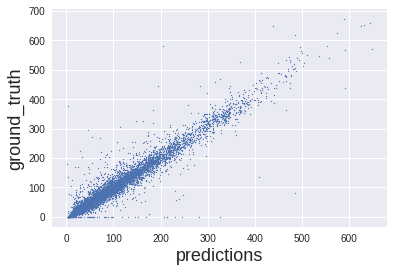

In [29]:
plt.scatter(x=df_results['predictions'],y=df_results['ground_truth'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()

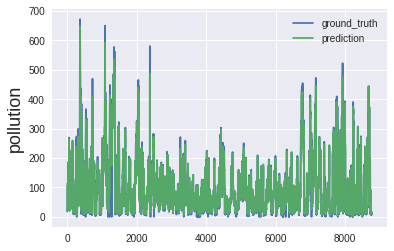

In [30]:
plt.plot(df_results['ground_truth'])
plt.plot(df_results['predictions'])
plt.ylabel('pollution',fontsize=18)
plt.legend(['ground_truth','prediction'])
plt.show()

# Let's now try to predict 5 steps ahead
- this time, we'll put everything into one notebook cell

In [31]:
df2 = df.copy()
num_lags = 5 # number of lags and window lenghts for mean aggregation
delay = 5 # predict target five steps ahead
for column in df2:
    for lag in range(1,num_lags+1):
        df2[column + '_lag' + str(lag)] = df2[column].shift(lag*-1-(delay-1))
        if column != 'wnd_dir':
            df2[column + '_avg_window_length' + str(lag+1)] = df2[column].shift(-1-(delay-1)).rolling(window=lag+1,center=False).mean().shift(1-(lag+1))

df2.dropna(inplace=True) 

mask = (df2.columns.str.contains('pollution') | df2.columns.str.contains('lag') | df2.columns.str.contains('window'))
df_processed = df2[df2.columns[mask]]

df_processed.reset_index(drop=True,inplace=True)
df_train = df_processed.loc[:int(df_processed.shape[0]*0.8),:]
df_test = df_processed.loc[int(df_processed.shape[0]*0.8):,:]

hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

y = 'pollution'
x = hf_train.columns
x.remove(y)

aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42)
aml.train(x = x, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

leader_model = aml.leader

hf_test_predict = leader_model.predict(hf_test)

df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['pollution'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)

slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_results['predictions'],y=df_results['ground_truth'])
print('R2 = ',r_value*r_value)



Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
R2 =  0.6740027842197897


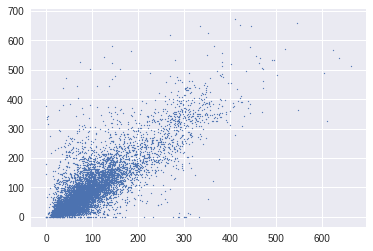

In [32]:
plt.scatter(x=df_results['predictions'],y=df_results['ground_truth'],s=1)
plt.show()

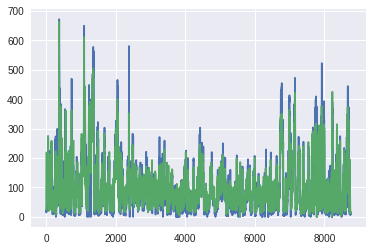

In [33]:
plt.plot(df_results['ground_truth'])
plt.plot(df_results['predictions'])
plt.show()

## Things to Try:
- compare with univarate model
- compare with LSTM

## Close h2o session

In [34]:
h2o.cluster().shutdown()

H2O session _sid_80c8 closed.
